# Hashtag correlation

This code creates new fields with multiple hashtags for each tweet and one field with popular hashtags.
Credits go to [Our Coding Club and James](https://ourcodingclub.github.io/tutorials/topic-modelling-python/).

Some preprocessing in the form of new modules:

In [172]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import nan

# model building package
import sklearn

# package to clean text
import re

In [173]:
src = "../Updates"

df = pd.read_csv(join(src, 'IchBinHanna.csv'), encoding='utf-8', dtype='unicode', 
                   parse_dates=['created_at'])

In [174]:
# This code only executes with the second file section directly above
def find_hashtags(tagstring):
    if tagstring == tagstring:
        list_of_dicts = eval(tagstring)
        hashtags = []
        for dct in list_of_dicts:
            tag = dct['tag']
            hashtags.append(tag)
        return hashtags
    else:
        return np.nan
    
df['hashtags'] = df['entities.hashtags'].apply(find_hashtags, lambda col: col.str.lower())

df = df.dropna(subset=['hashtags']) # delete empty rows

In [175]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = df.loc[
                       df.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['hashtags']]

# create dataframe where each use of hashtag gets its own row. The complicated function is called "list comprehension"
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])


flattened_hashtags_df

,hashtag
0,IchBinHanna
1,IchBinHanna
2,IchBinHanna
3,IchBinHanna
4,IchBinHanna
...,...
56830,ichbinhanna
56831,IchbinHanna
56832,Wissenschaft
56833,TenureTrack


IchBinHanna.csv

In [211]:
# number of unique hashtags
flattened_hashtags_df['hashtag'].unique().size

# Merge certain similar terms
## Option 1: Select and replace individually with a lamba loop. Quick and dirty, slow execution
## flattened_hashtags_df['hashtag'] = flattened_hashtags_df['hashtag'].apply(
##    lambda x: x.replace("fahrrad", "Fahrrad")) # Merge certain singular words

## Option 2: Select and replace with one call and regex. More elegant.
## Preprocessing hashtags for Radverkehr.csv

flattened_hashtags_df['hashtag'] = flattened_hashtags_df.replace({'hashtag' : 
                                                                  {'IchbinHanna' : 'IchBinHanna', 'ichbinhanna' : 'IchBinHanna',
                                                                   'IchbinHannah' : 'IchBinHannah', 'ichbinhannah' : 'IchBinHannah',
                                                                   'bmbf' : 'BMBF',
                                                                   'HannaimBundestag' : 'HannaImBundestag',
                                                                   'HannahimBundestag' : 'HannaImBundestag',
                                                                   'BIPOC' : 'BIPOCs',
                                                                   'Arbeitsbedigungen' : 'Arbeitsbedingungen',
                                                                   'Ads_Campaign' : 'SPAM',
                                                                   'Social_Media_Marketing': 'SPAM',
                                                                   'Digital_Marketing' : 'SPAM',
                                                                   'Facebook_Marketing' : 'SPAM',
                                                                   'Facebook_ads' : 'SPAM'}
                                                                    }, regex=True)
                                                                

# Remove punctuation (should be removed anyways)
# flattened_hashtags_df['hashtag'] = flattened_hashtags_df['hashtag'].str.replace('[^\w\s]','', regex=True)

In [195]:
# Print the top 10
flattened_hashtags_df.value_counts('hashtag')[0:50]

hashtag
IchBinHanna                    34547
WissZeitVG                      3238
HannaImBundestag                3219
IchBinHannah                    1121
ichbinHanna                      653
Wissenschaft                     426
95vsWissZeitVG                   403
Bundestag                        332
BMBF                             323
Karliczek                        293
SPAM                             270
Dauerstellen                     219
acertaindegreeofflexibility      169
OpenAccess                       136
DigitalHumanities                131
WoistHanna                       101
HannaStreikt                      97
IchwarHanna                       90
Befristung                        89
Corona                            85
wisskomm                          81
ACertainDegreeOfFlexibility       80
Streik                            78
Arbeitsbedigungen                 69
FrististFrust                     68
letzte3semester                   67
Forschung                     

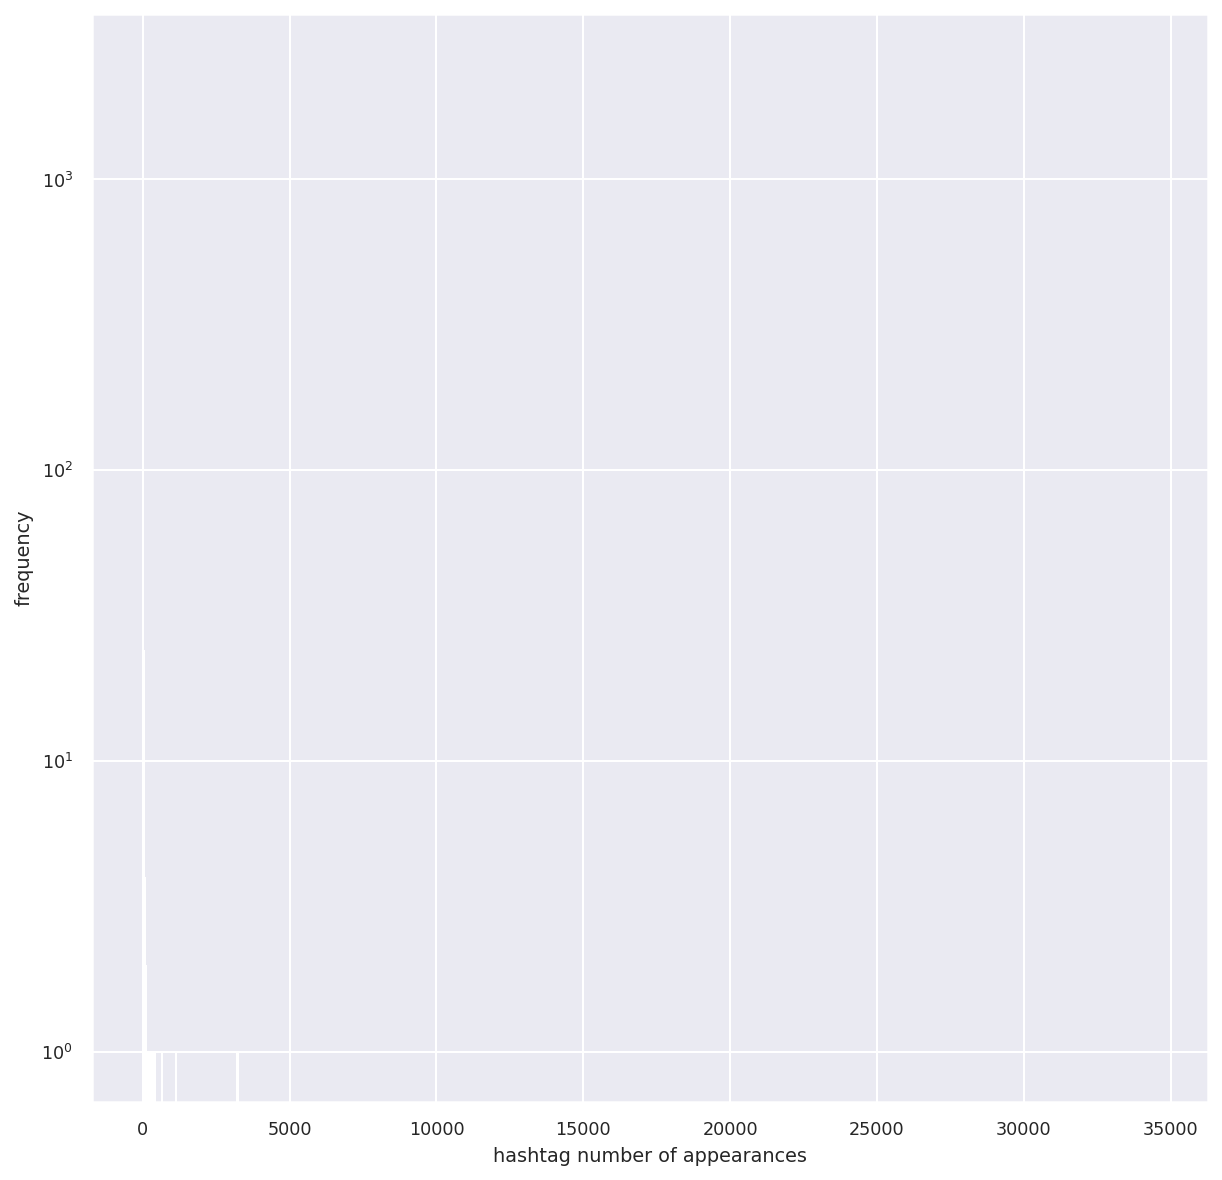

In [212]:
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

# number of times each hashtag appears
counts = flattened_hashtags_df.groupby(['hashtag']).size()\
                              .reset_index(name='counts')\
                              .counts

# define bins for histogram                              
my_bins = np.arange(0,counts.max()+2, 5)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonpositive='clip')
plt.show()


## Vectorization: See how hashtags are related to each other
Let's prepare data first, building on the slower approach above

In [213]:
# take hashtags which appear at least this amount of times. Increase min_appearance if graph below is too large
min_appearance = 50
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]

# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]


for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

# hashtag_vector_df.head # Uncommen this to see how the vector is coded

In [214]:
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

# calculate the correlation matrix
correlations = hashtag_matrix.corr()

### Correlation matrix: seaborn

Now this is what we're doing below:
We want to find the correlation between each column of the dataframe and thus the correlation between the different hashtags appearing in the same tweets.
As defined above, e can’t correlate hashtags which only appear once, and we don’t want hashtags that appear a low number of times since this could lead to spurious correlations.

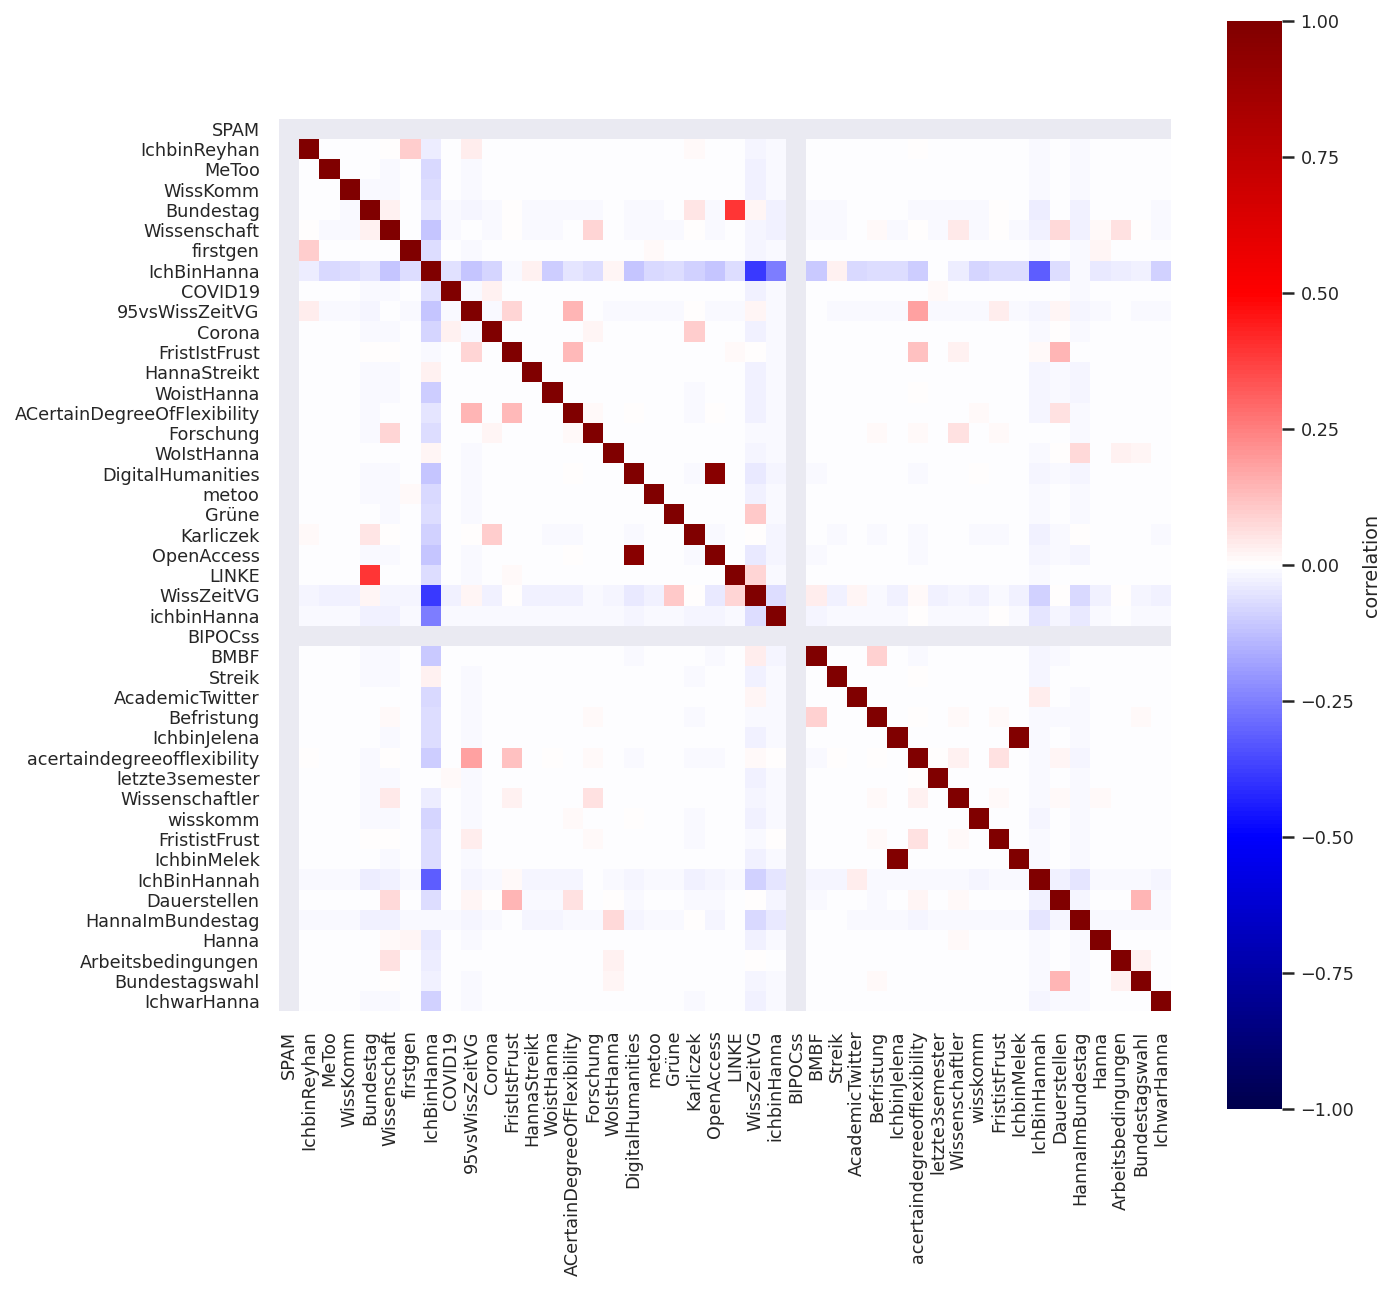

In [215]:
import seaborn as sns

# model building package
import sklearn

# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
    cmap='seismic', # RdBu, GnBu, seismic, bwr, magma More https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
    vmin=-1,
    vmax=1,
    square = True,
    # annot = True, fmt='.1', # To get numbers
    cbar_kws={'label':'correlation'}) # perhaps include , 'orientation': 'horizontal'


plt.savefig("../hashtag_correlation_Hanna.png", dpi=400)
plt.show()

### Correlation matrix: heatmapz
The difference below is that we get the size of correlation, which is directly related to the colour. Readability is thus improved. More [info on the module's website](https://pypi.org/project/heatmapz/)

In [216]:
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [217]:
# !pip install heatmapz

In [218]:
# Import the two methods from heatmap library
from heatmap import heatmap, corrplot

Create correlation matrix with size

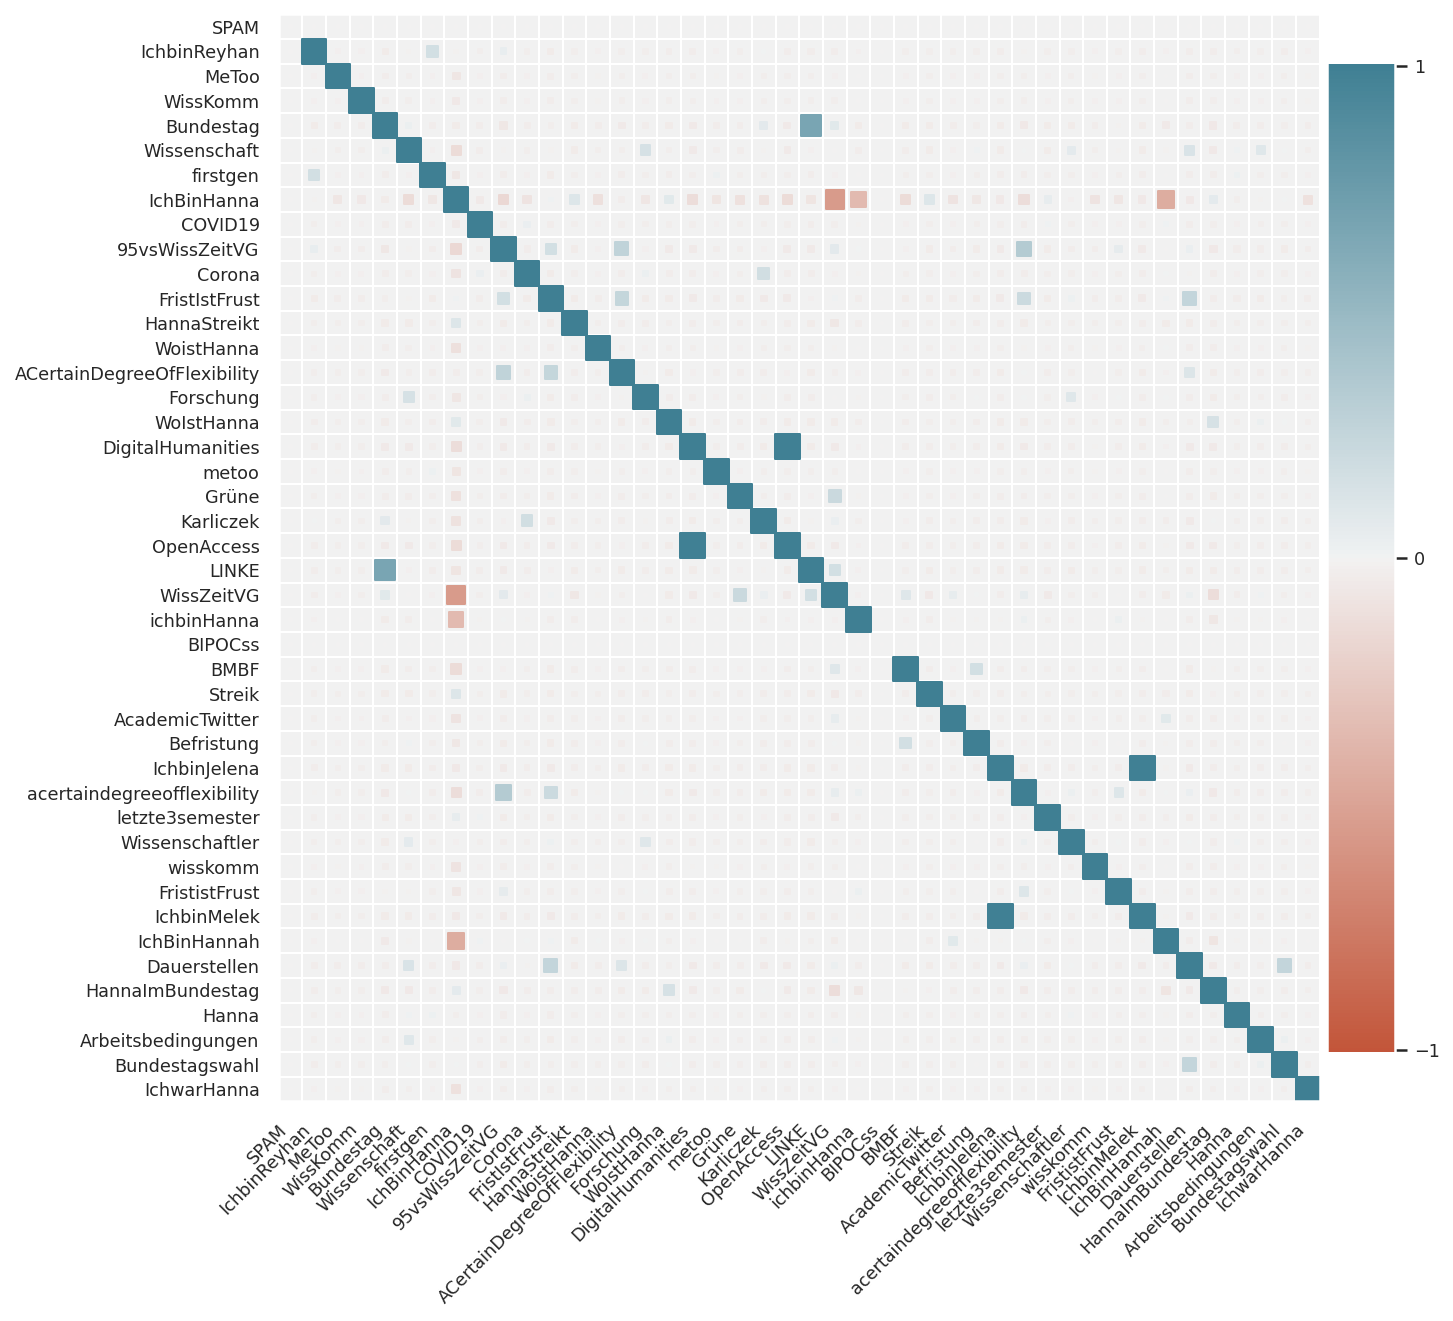

In [219]:
rcParams['figure.figsize'] = 10,10 
sns.set(color_codes=True, font_scale=0.8)
plt.figure(figsize=(10, 10))
corrplot(correlations.corr(), size_scale=150) 
# Adjust size-scale according to figure size. 
# Increasing the scale improves readability but also distorts
# Use marker='' for different shapes. 
# See also https://matplotlib.org/stable/api/markers_api.html
# For colours see https://seaborn.pydata.org/tutorial/color_palettes.html

plt.savefig("/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/plots/hashtag_correlation_Hanna_heatmapz.png", dpi=400)